In [1]:
from math import *
from haversine import haversine

In [2]:
taxi = pd.read_csv('../data/train.csv')

In [3]:
taxi.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


In [4]:
from ipyleaflet import *
import time

In [5]:
center = [40.766321, -73.965457]
zoom = 13
m = Map(center=center, zoom=zoom)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[40.766321, -73.965457], default_tiles=TileLayer(max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size']), layers=(TileLayer(max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size']),), layout=Layout(align_self='stretch', height='400px'), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=13)

In [6]:
import folium
import json
geo_path = '../data/geojson/state.geo.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

In [7]:
map = folium.Map(location=[40.766321, -73.965457], zoom_start=10.5)

for idx, row in taxi[:150].iterrows():
    if pd.notnull(row["pickup_latitude"]):
        folium.Marker([row['pickup_latitude'], row['pickup_longitude']]).add_to(map)
        
map

In [8]:
# 승객 수 0명 데이터 제거

In [9]:
# 운행 시간 0, 2시간 벗어나는 데이터 제거

taxi = taxi[taxi["trip_duration"] >= 0]
taxi = taxi[taxi["trip_duration"] <= 60*60*2]

In [10]:
# 뉴욕 시 경계를 벗어나는 위/경도 제거

# city_long_border = (-74.03, -73.75)
# city_lat_border = (40.63, 40.85) 

taxi = taxi[taxi['pickup_longitude'] <= -73.75]
taxi = taxi[taxi['pickup_longitude'] >= -74.03]
taxi = taxi[taxi['pickup_latitude'] <= 40.85]
taxi = taxi[taxi['pickup_latitude'] >= 40.63]
taxi = taxi[taxi['dropoff_longitude'] <= -73.75]
taxi = taxi[taxi['dropoff_longitude'] >= -74.03]
taxi = taxi[taxi['dropoff_latitude'] <= 40.85]
taxi = taxi[taxi['dropoff_latitude'] >= 40.63]

In [11]:
pickup_lat = tuple(taxi["pickup_latitude"])
pickup_lng = tuple(taxi["pickup_longitude"])
dropoff_lat = tuple(taxi["dropoff_latitude"])
dropoff_lng = tuple(taxi["dropoff_longitude"])

In [12]:
pickup_loc = tuple(zip(pickup_lat, pickup_lng))
dropoff_loc = tuple(zip(dropoff_lat, dropoff_lng))

In [13]:
print(len(pickup_loc))
print(len(dropoff_loc))

1436992
1436992


In [14]:
# vincenty distacne
import geopy.distance
from tqdm import tqdm_notebook

vincenty_distance = []
for i in tqdm_notebook(range(len(pickup_loc))):
    vincenty_distance.append(geopy.distance.vincenty(pickup_loc[i], dropoff_loc[i]).km)

HBox(children=(IntProgress(value=0, max=1436992), HTML(value='')))

In [15]:
taxi.loc[:, "vincenty_distance"] = vincenty_distance
taxi.loc[:, ["id", "vincenty_distance"]].head()

,id,vincenty_distance
0,id2875421,1.502172
1,id2377394,1.808660
2,id3858529,6.379687
3,id3504673,1.483632
4,id2181028,1.187038


In [16]:
# def haversine_array(lat1, lng1, lat2, lng2):
#     lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
#     AVG_EARTH_RADIUS = 6371  # in km
#     lat = lat2 - lat1
#     lng = lng2 - lng1
#     d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
#     h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
#     return h

In [17]:
# haversine distance

# taxi["haversine_distance"] = taxi.apply(lambda row: haversine(
#     (row["pickup_latitude"], row["pickup_longitude"]), 
#     (row["dropoff_latitude"], row["dropoff_longitude"])), axis=1)

# taxi["log_haversine_distance"] = np.log1p(taxi["haversine_distance"]) 

In [18]:
# taxi.loc[:, ["vincenty_distance", "haversine_distance"]].sort_values("vincenty_distance", ascending=False).head(5)

,vincenty_distance,haversine_distance
87724,27.196781,27.191629
181710,26.584701,26.591816
1140932,26.502783,26.502205
311326,26.450524,26.457531
810978,26.342429,26.351315


In [19]:
taxi["duration_min"] = taxi["trip_duration"] / 60.0
taxi["log_duration"] = np.log1p(taxi["duration_min"])
taxi["log_vincenty_distance"] = np.log1p(taxi["vincenty_distance"])

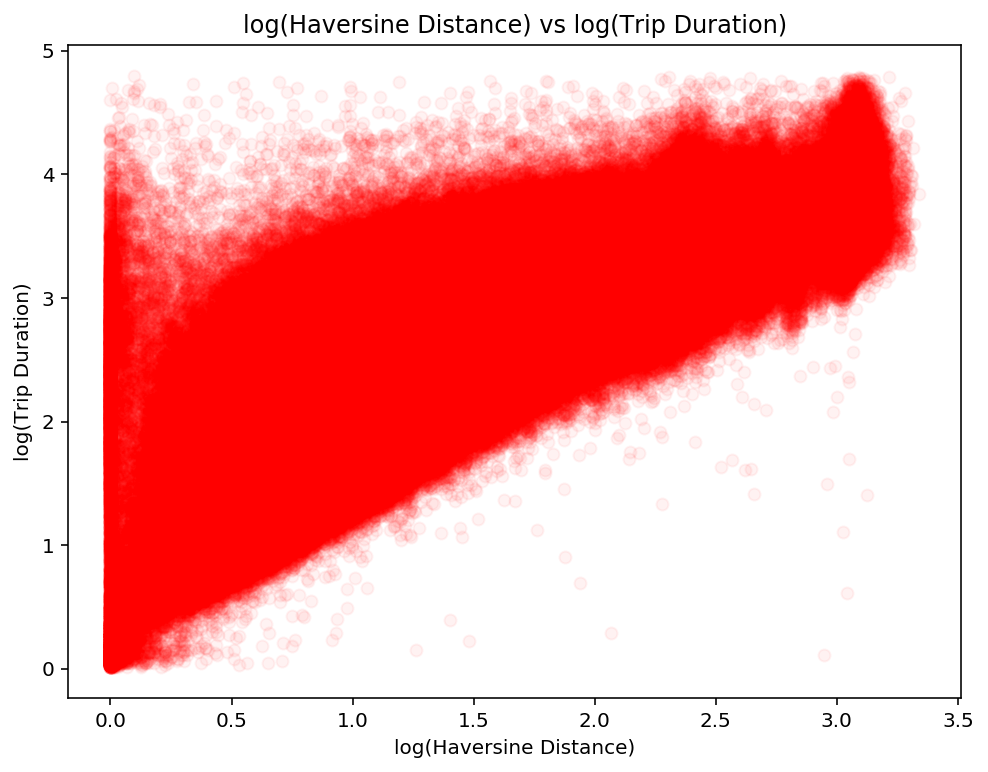

In [20]:
#%% plot scatter of trip duration vs. aerial distance between pickup and dropoff

# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6))

# ax[0].scatter(taxi["vincenty_distance"], taxi["duration_min"], c='r', s=5, alpha=0.01); 
# ax[0].set_xlabel("Vincenty distance (km)"); ax[0].set_ylabel("Trip duration (min)")
# ax[0].set_xlim(taxi["vincenty_distance"].min(), taxi["vincenty_distance"].max())
# ax[0].set_ylim(taxi["duration_min"].min(), taxi["duration_min"].max())
# ax[0].set_title("Trip duration vs Vincenty trip distance")

# ax[1].scatter(taxi["log_vincenty_distance"], taxi["duration_min"], c='r', s=5, alpha=0.01); 
# ax[1].set_xlabel("log(1+Vincenty distance) (km)"); ax[1].set_ylabel("Trip duration (min)")
# ax[1].set_xlim(taxi["log_vincenty_distance"].min(), taxi["log_vincenty_distance"].max())
# ax[1].set_ylim(taxi["duration_min"].min(), taxi["duration_min"].max())
# ax[1].set_title("Trip duration vs Log of vincenty trip distance")

# ax[2].scatter(taxi["log_vincenty_distance"], taxi["log_duration"], c='r', s=5, alpha=0.01); 
# ax[2].set_xlabel("log(1+Vincenty distance) (km)"); ax[2].set_ylabel("log(1+Trip duration) (min)")
# ax[2].set_xlim(taxi["log_vincenty_distance"].min(), taxi["log_vincenty_distance"].max())
# ax[2].set_ylim(taxi["log_duration"].min(), taxi["log_duration"].max())
# ax[2].set_title("Log of Trip duration vs Log of vincenty trip distance")


# plt.figure(figsize=(8, 6))
# plt.scatter(taxi.log_vincenty_distance, taxi.log_duration ,color="r", alpha=0.05)
# plt.ylabel("log(Trip Duration)")
# plt.xlabel("log(Vincenty Distance)")
# plt.title("log(Vincenty Distance) vs log(Trip Duration)");

plt.figure(figsize=(8, 6))
plt.scatter(taxi.log_haversine_distance, taxi.log_duration ,color="r", alpha=0.05)
plt.ylabel("log(Trip Duration)")
plt.xlabel("log(Haversine Distance)")
plt.title("log(Haversine Distance) vs log(Trip Duration)");

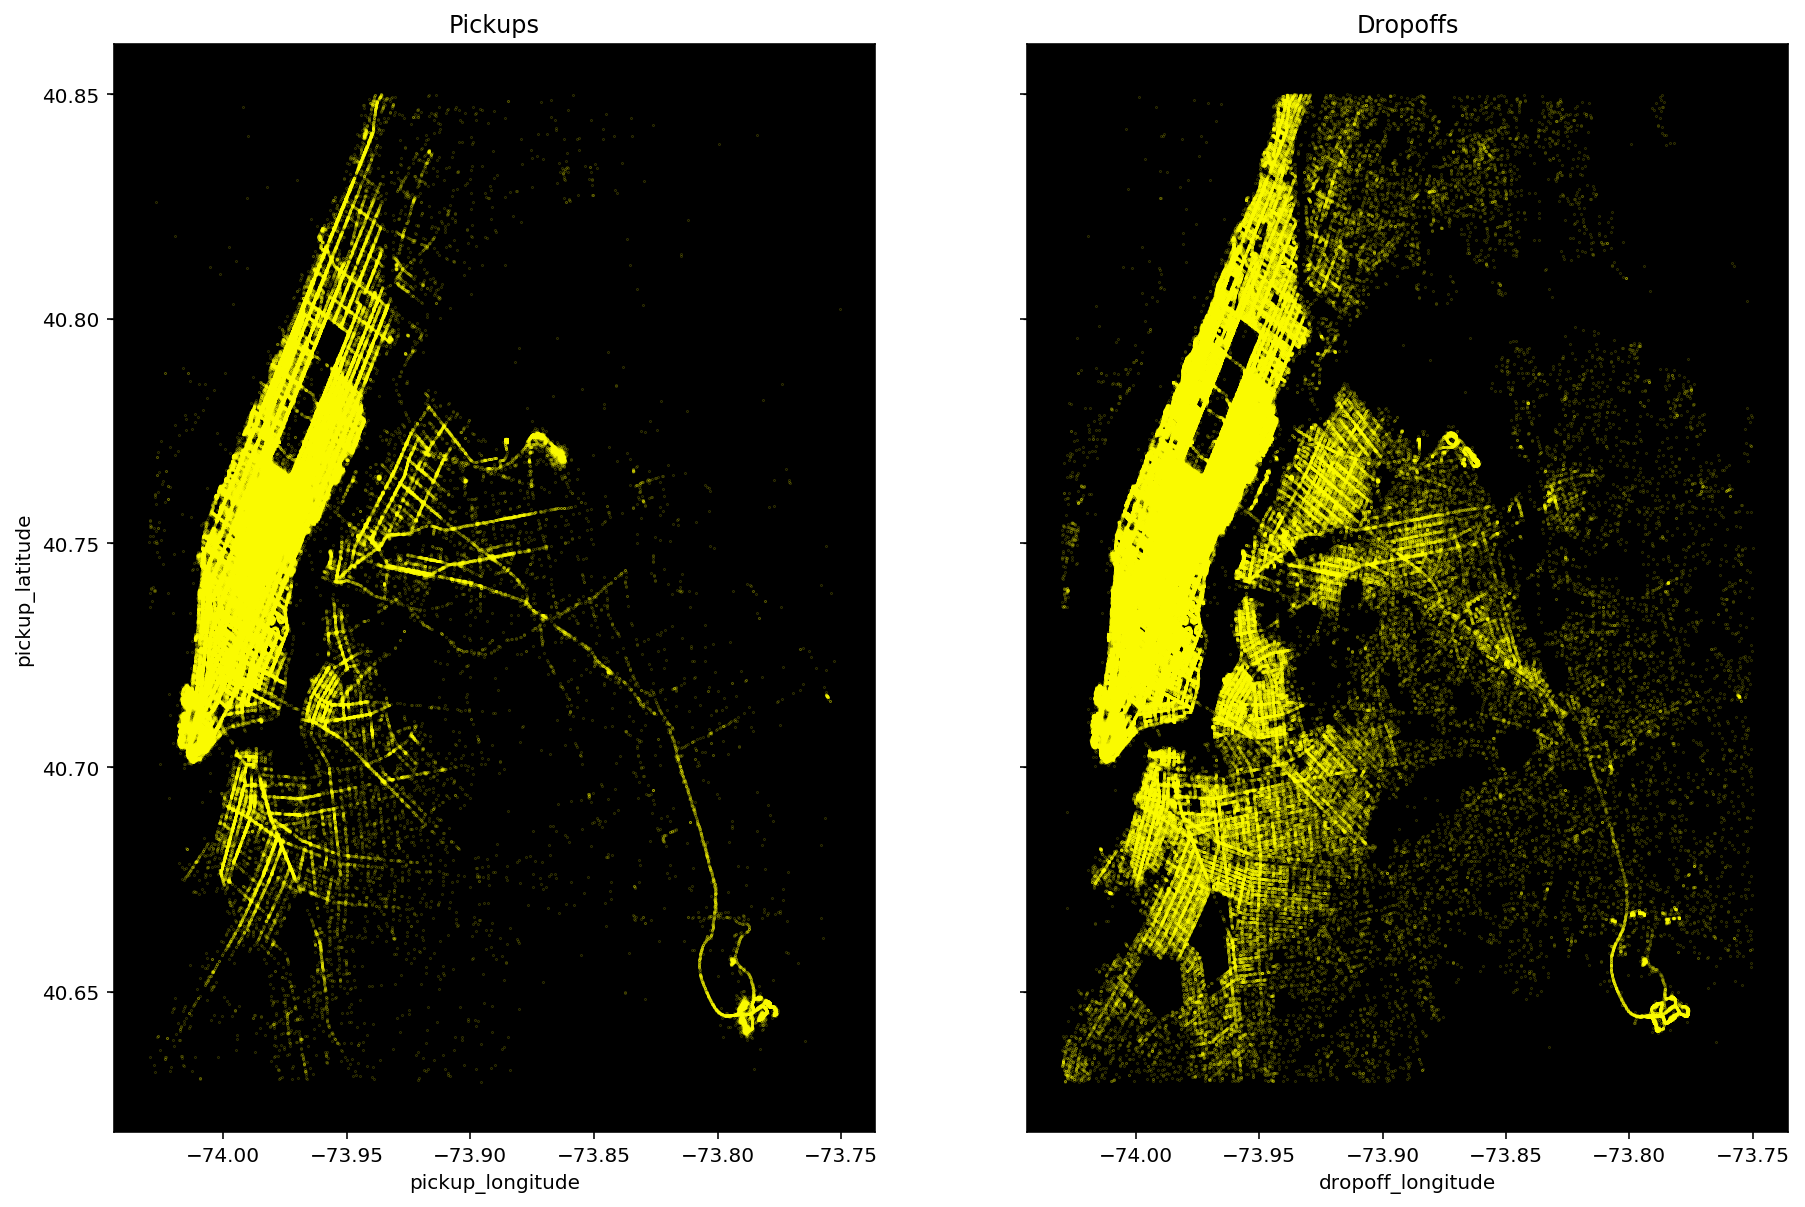

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

taxi.plot(kind="scatter", x="pickup_longitude", y="pickup_latitude",
                color="yellow", 
                s=.02, alpha=.6, subplots=True, ax=ax1)

ax1.set_title("Pickups")
ax1.set_facecolor("black")

taxi.plot(kind="scatter", x="dropoff_longitude", y="dropoff_latitude",
                color="yellow", 
                s=.02, alpha=.6, subplots=True, ax=ax2)

ax2.set_title("Dropoffs")
ax2.set_facecolor("black") 

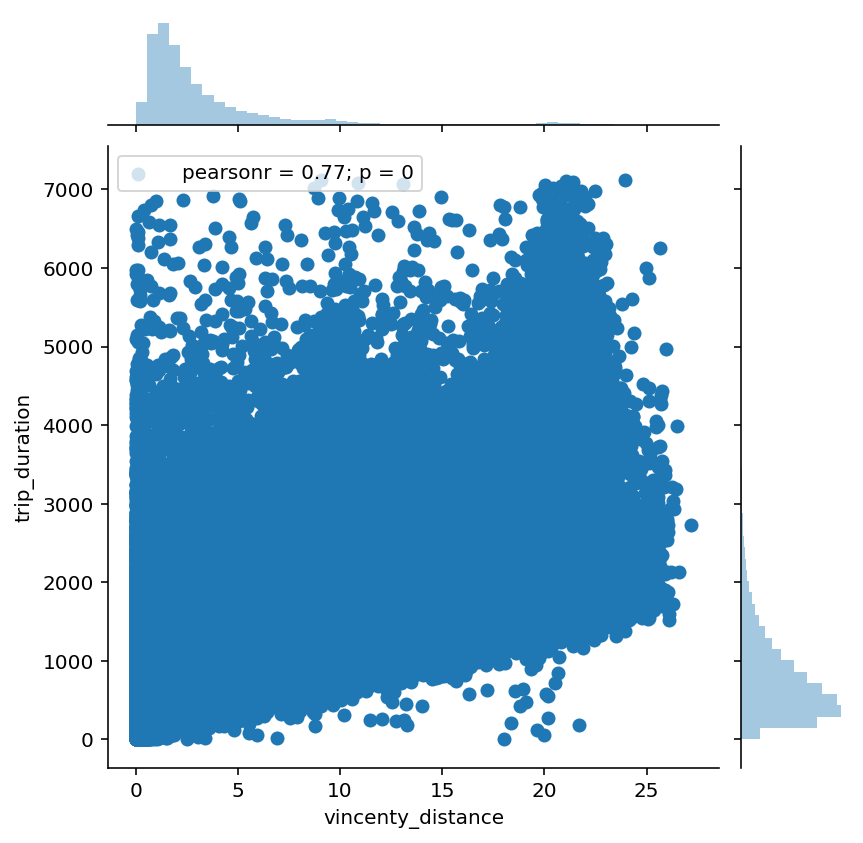

In [22]:
sns.jointplot(x="vincenty_distance", y="trip_duration", data=taxi);

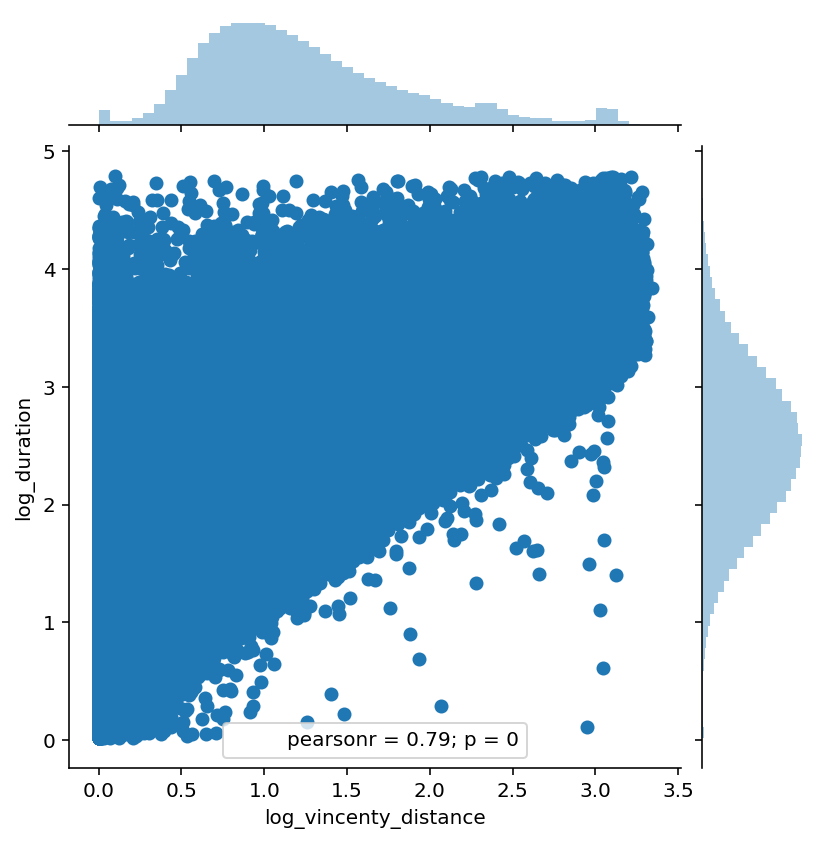

In [23]:
sns.jointplot(x="log_vincenty_distance", y="log_duration", data=taxi);

In [25]:
taxi["pickup_datetime"] = pd.to_datetime(taxi.pickup_datetime)

taxi.loc[:, "pickup_weekday"] = taxi["pickup_datetime"].dt.weekday
taxi.loc[:, "pickup_hour_weekofyear"] = taxi["pickup_datetime"].dt.weekofyear
taxi.loc[:, "pickup_hour"] = taxi["pickup_datetime"].dt.hour
taxi.loc[:, "pickup_minute"] = taxi["pickup_datetime"].dt.minute
taxi.loc[:, "pickup_dt"] = (taxi["pickup_datetime"] - taxi["pickup_datetime"].min()).dt.total_seconds()
taxi.loc[:, "pickup_week_hour"] = taxi["pickup_weekday"] * 24 + taxi["pickup_hour"]

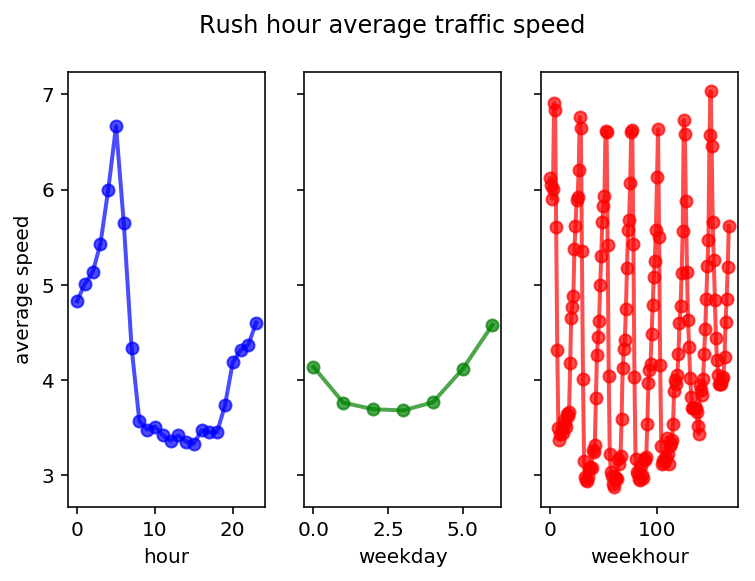

In [27]:
taxi.loc[:, "avg_speed_h"] = 1000 * taxi["vincenty_distance"] / taxi["trip_duration"]
# taxi.loc[:, "avg_speed_m] = 1000 * taxi["distance_dummy_manhattan] / taxi["trip_duration"]

fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(taxi.groupby("pickup_hour").mean()["avg_speed_h"], 'bo-', lw=2, alpha=0.7)
ax[1].plot(taxi.groupby("pickup_weekday").mean()["avg_speed_h"], 'go-', lw=2, alpha=0.7)
ax[2].plot(taxi.groupby("pickup_week_hour").mean()["avg_speed_h"], 'ro-', lw=2, alpha=0.7)

ax[0].set_xlabel("hour")
ax[1].set_xlabel("weekday")
ax[2].set_xlabel("weekhour")

ax[0].set_ylabel("average speed")
fig.suptitle("Rush hour average traffic speed")
plt.show()

In [ ]:
# import gmplot
# gmap = gmplot.GoogleMapPlotter(40.766321, -73.965457, 11)

# gmap.plot(pickup_lat[:100], pickup_lng[:100], 'cornflowerblue', edge_width=10)
# gmap.scatter(pickup_lat[:100], pickup_lng[:100], '#3B0B39', size=40, marker=False)
# gmap.scatter(dropoff_lat[:100], dropoff_lng[:100], 'k', marker=True)

# gmap.draw("mymap.html")

In [ ]:
# west, south, east, north = -74.03, 40.63, -73.77, 40.85

# train = train[(train.pickup_latitude> south) & (train.pickup_latitude < north)]
# train = train[(train.dropoff_latitude> south) & (train.dropoff_latitude < north)]
# train = train[(train.pickup_longitude> west) & (train.pickup_longitude < east)]
# train = train[(train.dropoff_longitude> west) & (train.dropoff_longitude < east)]

In [ ]:
# def manhattan_distance(x,y):
#     return sum(abs(a-b) for a,b in zip(x,y))

# def euclidean_distance(x,y):
#     return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

# taxi['euclidean_distance'] = taxi.apply(lambda row: euclidean_distance(
#     (row['pickup_latitude'], row['pickup_longitude']),
#     (row['dropoff_latitude'], row['dropoff_longitude'])), axis=1)

# taxi['log_euclidean_distance'] = np.log1p(taxi['euclidean_distance'])